# Fitting Local Edge-Triangle ERGM

In this notebook, we will attempt to fit an ERGM on undirected graphs with edge density and _local_ triangle density as its sufficient statistics. We define a metric $d(i, j)$ on nodes, and then the local triangle density statistic $t(G)$ is defined as
$$t(G) = \frac{\textrm{# of local triangles in G}}{\textrm{# number of local triangles if G were complete}},$$
where a local triangle is a set of three distinct nodes ${i, j, k}$ in $G$ such that $d(i, j), d(j, k), d(k, i) < r$ for some fixed radius $r$ and there are edges $i-j, j-k, k-i$ in $G$.

In [2]:
import Pkg
Pkg.activate("..")

  Activating project at `~/research/xaqlab/ergm.jl`


## Define Sufficient Statistics and Their Update Rules
Locations of the 50 nodes are uniformly sampled in $[0, 1]^3$.

In [3]:
using ergm.stats
using LinearAlgebra

n = 50
node_locations = rand(3, 50)
node_metric = [
    norm(node_locations[i] - node_locations[j])
    for i ∈ 1:n, j ∈ 1:n
]
local_radius = 0.2
local_mask = node_metric .< local_radius

max_edge_count = n * (n - 1) / 2
max_local_triangle_count = sum(local_mask ^ 2 .* local_mask) / 6

sufficient_statistics = DeltaStats(
    function(G)
        n = G.n
        A = G.adjacency
        
        edge_count = sum(A) / 2
        edge_density = edge_count / max_edge_count
        
        local_A = local_mask .* A
        local_triangle_count = sum(local_A ^ 2 .* local_A) / 6
        local_triangle_density = local_triangle_count / max_local_triangle_count
        
        [edge_density, local_triangle_density]
    end,
    function(G, current_statistics, update)
        n = G.n
        A = G.adjacency
        ix, x = update
        i, j = ix
        
        delta_edge_count = x - G[ix]
        delta_edge_density = delta_edge_count / max_edge_count
        
        local_A = local_mask .* A
        delta_local_triangle_count = (x - G[ix]) * local_mask[i, j] * sum(local_A[i, :] .* local_A[:, j])
        delta_local_triangle_density = delta_local_triangle_count / max_local_triangle_count
        
        current_statistics .+ [delta_edge_density, delta_local_triangle_density]
    end
)

DeltaStats(var"#3#5"(), var"#4#6"(), UndefInitializer(), UndefInitializer())

In [8]:
# percentage of total possible edges which are considered "local"
(sum(local_mask) - n) / (n * (n - 1)) * 100

33.46938775510204

In [9]:
# percentage of total possible triangles which are considered "local"
max_local_triangle_count / (n * (n - 1) * (n - 2) / 6) * 100

11.170068027210885

## Define Ground-Truth ERGM

In [14]:
using ergm.models
using ergm.sampler
using Statistics

model = ExponentialFamily(sufficient_statistics, [-1e3, 1e3])
sampler = ParallelGibbsSampler(
    Graph(zeros(Bool, n, n)), model, 3, 5, Threads.nthreads()
);

# Verify Ground-Truth is Far From Erdős–Rényi Regime
As desired, local triangles are vastly over-represented in the ERGM (with natural parameters that I easily guessed for this purpose and are not precisely tuned).

In [15]:
function expectation_ergm(θe, θt)
    m = 100
    update_sampler_params(sampler, [θe, θt])
    _, ss = sample(sampler, m)
    mean(ss, dims=2)
end

function expectation_er(p)
    m = 100
    ss = hcat([get_stats(sufficient_statistics, Graph(rand(n, n) .< p)) for i ∈ 1:m]...)
    mean(ss, dims=2)
end

expectation_er (generic function with 1 method)

In [ ]:
e_ergm = expectation_ergm(-1e3, 1e3)

2×1 Matrix{Float64}:
 0.5329959183673514
 0.7489083390764975

In [ ]:
e_er = expectation_er(e_ergm[1])

2×1 Matrix{Float64}:
 0.5339510204081634
 0.12446175051688486

## Attempt to Recover Ground-Truth Parameters via SGD

In [137]:
using ergm.optim
using ergm.inference

θ_gt = [-1e3, 1e3]
update_params(model, θ_gt)
update_sampler_params(sampler, θ_gt)
Gs, _ = sample(sampler, 100)
update_params(model, [0.0, 0.0])
optimizer = SGD(1e2, [0.0, 0.0], 300, 0.0, "log.txt")
θs, Ls, target_Es, Es = mcmc_mle(Gs, model, optimizer, 1000, 5, 3);

## Results for Recovering Expectation Parameters

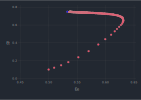

In [176]:
using Gadfly
using DataFrames

Gadfly.push_theme(:dark)
Es_mat = hcat(Es...)
df = DataFrame(:Ee => Es_mat[1, :], :Et => Es_mat[2, :])
plot(
    layer(df, x=:Ee, y=:Et, Geom.point),
    layer(x=[target_Es[1]], y=[target_Es[2]], Geom.point, color=[colorant"blue"])
)

## Results for Recovering Natural Parameters

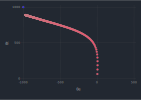

In [175]:
df = DataFrame(:θe => θs[1, :], :θt => θs[2, :])
plot(
    layer(df, x=:θe, y=:θt, Geom.point),
    layer(x=[θ_gt[1]], y=[θ_gt[2]], color=[colorant"blue"])
)